# Possible to beat Random Walk using RF?
## With Apple stock as an example

In [3]:


# Data handling
import pandas as pd
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt

# Random forest modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix


## 1.0) Data preparation

In [4]:
ticker = "AAPL"

# Define start dates and download data
start = datetime.datetime(2011, 1, 1)
end = datetime.datetime(2019, 12, 31)

df_aapl = yf.download(ticker, start = start, end = end)

del df_aapl["Adj Close"]

df_aapl.head()
#df_aapl.tail()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2011-01-03,11.630000,11.795000,11.601429,11.770357,445138400
2011-01-04,11.872857,11.875000,11.719643,11.831786,309080800
2011-01-05,11.769643,11.940714,11.767857,11.928571,255519600
2011-01-06,11.954286,11.973214,11.889286,11.918929,300428800
2011-01-07,11.928214,12.012500,11.853571,12.004286,311931200


### 1.1) Adding features

In [5]:
# List of rolling average horizons
horizons = [2, 5, 60, 250]

# calculate rolling averages
def calculate_rolling_averages(df, horizons):
    for horizon in horizons:
        rolling_avg = df["Close"].rolling(window=horizon).mean()
        df[f"Rolling_Average_{horizon}"] = rolling_avg
    return df

df_aapl = calculate_rolling_averages(df_aapl, horizons)

# Lagged return
def lag_return(df_aapl, lag):
    return np.log(df_aapl["Close"] / df_aapl["Close"].shift(lag))

# Overnight move
def overnight_move(df_aapl):
    return np.log(df_aapl["Open"] / df_aapl["Close"].shift(1))

# Moving average
def moving_average(df_aapl, window):
    return df_aapl["Close"].rolling(window=window).mean()

# Trend
def trend(df_aapl):
    return (df_aapl["Close"] - df_aapl["Close"].shift(5)) / df_aapl["Close"].shift(5)

# Volatility
def volatility(df_aapl, lag):
    return np.log(df_aapl["High"] / df_aapl["Low"].shift(lag))

# Lagged volatility
def lagged_volatility_change(df_aapl):
    lagged_volatility = volatility(df_aapl, 2)
    lagged_volatility_shifted = lagged_volatility.shift(1)
    return np.where(lagged_volatility > lagged_volatility_shifted, 1, 0)

# Momentum 
def momentum(df_aapl, window):
    return lag_return(df_aapl, 1).rolling(window=window).sum()

# RSI
def calculate_rsi(df_aapl, window=14):
    delta = df_aapl["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Bollinger
def calculate_bollinger_bands(df_aapl, window=20, std_multiplier=2):
    rolling_mean = df_aapl["Close"].rolling(window=window).mean()
    rolling_std = df_aapl["Close"].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * std_multiplier)
    lower_band = rolling_mean - (rolling_std * std_multiplier)
    return upper_band, lower_band

# Calculate features
df_aapl["Today"] = np.where(lag_return(df_aapl, 1) > 0, 1, 0)
df_aapl["Lag1"] = lag_return(df_aapl, 1)
df_aapl["Lag2"] = lag_return(df_aapl, 2)
df_aapl["Lag5"] = lag_return(df_aapl, 5)
df_aapl["Lag60"] = lag_return(df_aapl, 60)
df_aapl["Lag250"] = lag_return(df_aapl, 250)
df_aapl["ON"] = overnight_move(df_aapl)
df_aapl["LagVolume"] = df_aapl["Volume"].shift(1)
df_aapl["LOGVOLUME"] = np.log(df_aapl["Volume"])
df_aapl["MA5"] = moving_average(df_aapl, 5)
df_aapl["MA20"] = moving_average(df_aapl, 20)
df_aapl["MOM5"] = momentum(df_aapl, 5)
df_aapl["MOM20"] = momentum(df_aapl, 20)
df_aapl["MOM100"] = momentum(df_aapl, 100)
df_aapl["Crossover"] = df_aapl["MA5"] - df_aapl["MA20"]
df_aapl["Trend"] = trend(df_aapl)
df_aapl["LagVolatility"] = volatility(df_aapl, 1)
df_aapl["Lag2Volatility"] = volatility(df_aapl, 2)
df_aapl["LagChangeVoll"] = lagged_volatility_change(df_aapl)

# Additional features (I don't know what this is, just suggested features from googling)
df_aapl["RSI"] = calculate_rsi(df_aapl)
upper_band, lower_band = calculate_bollinger_bands(df_aapl)
df_aapl["Upper_Band"] = upper_band
df_aapl["Lower_Band"] = lower_band

df_aapl.head()
#df_aapl.tail()


,Open,High,Low,Close,Volume,Rolling_Average_2,Rolling_Average_5,Rolling_Average_60,Rolling_Average_250,Today,...,MOM20,MOM100,Crossover,Trend,LagVolatility,Lag2Volatility,LagChangeVoll,RSI,Upper_Band,Lower_Band
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,11.630000,11.795000,11.601429,11.770357,445138400,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2011-01-04,11.872857,11.875000,11.719643,11.831786,309080800,11.801072,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,0.023307,NaN,0,NaN,NaN,NaN
2011-01-05,11.769643,11.940714,11.767857,11.928571,255519600,11.880178,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,0.018688,0.028826,0,NaN,NaN,NaN
2011-01-06,11.954286,11.973214,11.889286,11.918929,300428800,11.923750,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,0.017300,0.021406,0,NaN,NaN,NaN
2011-01-07,11.928214,12.012500,11.853571,12.004286,311931200,11.961607,11.890786,NaN,NaN,1,...,NaN,NaN,NaN,NaN,0.010310,0.020576,0,NaN,NaN,NaN


In [4]:
# Plot the aapl data
#df_aapl.plot.line(y = "Close", use_index = True)

### 1.2) Target variable

In [6]:
# Create a column called "Tomorrow" which, for each day, takes the value of the price tomorrow. 
df_aapl["Tomorrow"] = df_aapl["Close"].shift(-1)

df_aapl

,Open,High,Low,Close,Volume,Rolling_Average_2,Rolling_Average_5,Rolling_Average_60,Rolling_Average_250,Today,...,MOM100,Crossover,Trend,LagVolatility,Lag2Volatility,LagChangeVoll,RSI,Upper_Band,Lower_Band,Tomorrow
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,11.630000,11.795000,11.601429,11.770357,445138400,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,11.831786
2011-01-04,11.872857,11.875000,11.719643,11.831786,309080800,11.801072,NaN,NaN,NaN,1,...,NaN,NaN,NaN,0.023307,NaN,0,NaN,NaN,NaN,11.928571
2011-01-05,11.769643,11.940714,11.767857,11.928571,255519600,11.880178,NaN,NaN,NaN,1,...,NaN,NaN,NaN,0.018688,0.028826,0,NaN,NaN,NaN,11.918929
2011-01-06,11.954286,11.973214,11.889286,11.918929,300428800,11.923750,NaN,NaN,NaN,0,...,NaN,NaN,NaN,0.017300,0.021406,0,NaN,NaN,NaN,12.004286
2011-01-07,11.928214,12.012500,11.853571,12.004286,311931200,11.961607,11.890786,NaN,NaN,1,...,NaN,NaN,NaN,0.010310,0.020576,0,NaN,NaN,NaN,12.230357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,70.132500,71.062500,70.092499,71.000000,98572000,70.430000,70.180499,63.516083,51.50147,1,...,0.309371,2.385000,0.014793,0.020221,0.018822,1,85.446185,71.406074,64.184924,71.067497
2019-12-24,71.172501,71.222504,70.730003,71.067497,48478800,71.033749,70.373499,63.767333,51.62959,1,...,0.331706,2.354249,0.013766,0.015993,0.022470,1,84.544664,71.863032,64.175466,72.477501
2019-12-26,71.205002,72.495003,71.175003,72.477501,93121200,71.772499,70.881999,64.039500,51.76327,1,...,0.405120,2.542500,0.036355,0.024648,0.033702,1,85.353147,72.550129,64.128870,72.449997


In [7]:
# Based on tomorrow's price, we set up a target. This is what we try to predict with our modle
# Question: Is tomorrow's price greater than today's price?

# Create the target column, which will return a boolean value. We change it to a binary integer so we can use it in ML modeling
df_aapl["Target"] = (df_aapl["Tomorrow"] > df_aapl["Close"]).astype(int)

# 1 = Price went up (Tomorrow's price was greater than the price of today)
# 0 = Price went down (Tomorrow's price was lesser than the price of today)

# We have a lot of NAs (due to the calculation of features) which needs to be dropped before running the model
# This results in dropping almost the entire of 2011, as can be seen below
df_aapl = df_aapl.dropna()
df_aapl.head()

,Open,High,Low,Close,Volume,Rolling_Average_2,Rolling_Average_5,Rolling_Average_60,Rolling_Average_250,Today,...,Crossover,Trend,LagVolatility,Lag2Volatility,LagChangeVoll,RSI,Upper_Band,Lower_Band,Tomorrow,Target
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-29,14.407143,14.487500,14.303929,14.468571,215978000,14.424285,14.401214,14.001423,12.999217,1,...,0.389536,0.021869,0.010682,0.006505,0,64.011625,14.596694,13.426663,14.464286,0
2011-12-30,14.411071,14.510000,14.410357,14.464286,179662000,14.466428,14.447286,14.017345,13.009747,0,...,0.405125,0.016184,0.014304,0.012234,1,61.669436,14.655566,13.428755,14.686786,1
2012-01-03,14.621429,14.732143,14.607143,14.686786,302220800,14.575536,14.503714,14.037500,13.020780,1,...,0.423107,0.019587,0.022085,0.029497,1,68.220280,14.754604,13.406610,14.765714,1
2012-01-04,14.642857,14.810000,14.617143,14.765714,260022000,14.726250,14.553071,14.063476,13.032167,1,...,0.435982,0.016997,0.013792,0.027355,0,73.506416,14.856728,13.377450,14.929643,1
2012-01-05,14.819643,14.948214,14.738214,14.929643,271269600,14.847678,14.663000,14.080869,13.043869,1,...,0.497553,0.038223,0.022397,0.023081,0,89.123309,14.984707,13.346186,15.085714,1


## 2.0)  Model training

In [8]:
# THESE ARE OUR PREDICTORS
predictors = [
    "Close",
    "Volume",
    "Open",
    "High",
    "Low",
    "Lag1",
    "ON",
    "LagVolume",
    "LOGVOLUME",
    "MA5",
    "MA20",
    "MOM5",
    "MOM20",
    "MOM100",
    "Crossover",
    "Trend",
    "LagVolatility",
    "Lag2Volatility",
    "LagChangeVoll",
    "RSI",
    "Upper_Band",
    "Lower_Band"
]

# notes:
# n_estimators = Number of individual decision trees we want to train. The higher this is, generally the
# better accuracy, up to a limit. #NB EXPLAIN WHY 200, I just chose at random...
# min_samples_split = Helps us prevent overfitting. If we build the trees too deply they might overfit. 
# This also needs to be argued for, the splitting has been chosen at random
# random state = Setting the seed
model = RandomForestClassifier(n_estimators = 200, min_samples_split = 100, random_state = 1)

# # We split the data into a train and test set.
train = df_aapl.iloc[:-250] # All of the rows except the last 250 rows (2011-12-29 - 2018-12-31)
test = df_aapl.iloc[-250:] # Only the last 250 rows; The out-of-sample data. (2019-01-02 - 2019-12-27)

# # We will now fit the model. Interpretation: USE the "predictor" columns, in order to predict the "Target"
model.fit(train[predictors], train["Target"])



RandomForestClassifier(min_samples_split=100, n_estimators=200, random_state=1)

### 2.1)  Generate predictions

In [9]:
# The prediction function will wrap up everything we just did into a function
def predict(train, test, predictors, model): # Create a prediction function
    model.fit(train[predictors], train["Target"]) # 1) Fitting model using the training predictors and the target
    preds = model.predict(test[predictors]) # 2) Generating predictions
    preds = pd.Series(preds, index = test.index, name = "Predictions") # 3) Combining the model into a series
    combined = pd.concat([test["Target"], preds], axis = 1) # 4) Combining everything together
    return combined

## 3.0) Evaluation of performance

### 3.1) Backtest

In [10]:
# A backtest function which takes our APPLE data, our Ml model, our predictors, a start value and a step value.
# Start value = The data we use to train our first model. Every trading year has about 250 days.
# The model is being trained on the first 5 years (2012-2018)

def backtest(df_aapl, model, predictors, start = 1762, step = 250): #(1762 = 5 years)
    all_predictions = [] # Create an empy list
    
    for i in range(start, df_aapl.shape[0], step): # Function that loops across the data year by year
        train = df_aapl.iloc[0:i].copy()
        test = df_aapl.iloc[i:(i + step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [11]:
# Perform the backtest
predictions = backtest(df_aapl, model, predictors) # We backtest our aapl data with the model and predictors we created

In [12]:
predictions["Predictions"].value_counts() # See how many days we predicted the market would go up vs down
# 0 = We predicted that the market would go down this amount of times
# 1 = We predicted that the market would go up this amount of times

Predictions
1    162
0     88
Name: count, dtype: int64

### 3.2) Precision score

In [13]:
# Precision score
precision_score(predictions["Target"], predictions["Predictions"])
precision_score_rounded = round(precision_score(predictions["Target"], predictions["Predictions"]), 3)
print("Precision score:", precision_score_rounded)

# This is the percentage of days the model was correct. When the model predicted that the stock would go up, 60,5% of the time,
# the stock actually did go up

Precision score: 0.605


In [14]:
# As a benchmark, we can use the % of days where the market actually went up
predictions["Target"].value_counts() / predictions.shape[0]
# 1: In 2019, aapl went up this % of days
# 0: In 2019, aapl went down this % of days
# aapl went up 57,6% of the days, which is lower than the model performance (60,5%). We would have been better off following the model,
# compared to investing at radom every day. (Following a Random Walk) Our model performed a little bit better than he random walk.
# Interpretation: If we bought and sold at random every day during 2019, we would have performed worse than we would have by following
# the model suggestions. 

Target
1    0.576
0    0.424
Name: count, dtype: float64

### 3.3) Actual vs Predicted values

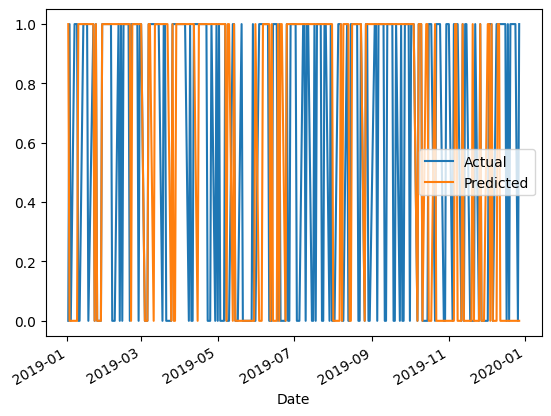

In [15]:
# # Plot our predictions by combining the actual values with our predicted ones.
# # axis = 1 treats each of the inputs as columns, not as rows
combined = pd.concat([predictions["Target"], predictions["Predictions"]], axis = 1)

# Rename the columns
combined.columns = ["Actual", "Predicted"]

# Filter data for the year 2019
combined_2019 = combined.loc["2019-01-01":"2019-12-31"]

# Plot the data for the year 2019
combined_2019.plot()

#Plot the data, "Predicted" is our predictions, "Target" is the actual values
plt.show()



### 3.4) Confusion matrix

In [16]:
# Create a confusion matrix
conf_matrix = confusion_matrix(predictions["Target"], predictions["Predictions"])


#------------ I do not print this matrix as I fail to show the "TP" in the top-left corner. It appears in the bottom-left,
#------------ which makes me confused and upset
#------------https://www.w3schools.com/python/python_ml_confusion_matrix.asp
print("Confusion Matrix:")
print(conf_matrix, "\n")

# Extract values from the confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

# Accuracy (Total number of correct classifications divded by the total number of cases)
accuracy = round((TP + TN) / (TP + FP + FN + TN), 3)

# Recall/Sensitivity (Total number of true positives divided by the total number of actual positives)
recall = round(TP / (TP + FN), 3)

# Precision (total number of true positives divided by the total number of predicted positives)
precision = round(TP / (TP + FP), 3)

# Specificity (Total number of ture negatives divided by the total number of actual negatives)
specificity = round(TN / (TN + FP), 3)

# F1-score (single metric that is a harmonic mean of precision and recall)
f1_score = round(2 * (precision * recall) / (precision + recall), 3)

#source: https://www.datacamp.com/tutorial/what-is-a-confusion-matrix-in-machine-learning



# Interpretations of the conf matrix
print("True Positive:", TP)
print("False Positive:", FP)
print("False Negative:", FN)
print("True Negative:", TN, "\n")

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Recall (Sensitivity):", recall)
print("Precision:", precision)
print("Specificity:", specificity)
print("F1-score:", f1_score, "\n")

print("The model correctly predicted", TP, "instances where the stoc price increased during the day and", TN, "instances where it decreased.")
print("However, it incorrectly predictes", FP, "instances as days when the stock price increased when it actually decreased, and", FN, "instances as days when the stock price decreased when it actually increased.")

Confusion Matrix:
[[42 64]
 [46 98]] 

True Positive: 98
False Positive: 64
False Negative: 46
True Negative: 42 

Accuracy: 0.56
Recall (Sensitivity): 0.681
Precision: 0.605
Specificity: 0.396
F1-score: 0.641 

The model correctly predicted 98 instances where the stoc price increased during the day and 42 instances where it decreased.
However, it incorrectly predictes 64 instances as days when the stock price increased when it actually decreased, and 46 instances as days when the stock price decreased when it actually increased.


### 3.5) Feature importance

In [17]:
# Convert the predictors list into a DataFrame
predictors_df = pd.DataFrame({'Feature': predictors})

# Feature importances
importances = model.feature_importances_

# DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': predictors_df['Feature'], 'Importance': importances})

# Sort the DataFrame by importance values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top N most important features
top_n = 100  # Change this number to see more or fewer features
print(feature_importance_df.head(top_n))

# Source: GPT


           Feature  Importance
12           MOM20    0.065814
11            MOM5    0.060304
13          MOM100    0.060175
5             Lag1    0.060022
19             RSI    0.056409
15           Trend    0.055162
8        LOGVOLUME    0.054682
16   LagVolatility    0.053634
1           Volume    0.053164
14       Crossover    0.051362
6               ON    0.051014
7        LagVolume    0.048772
9              MA5    0.041844
17  Lag2Volatility    0.041674
21      Lower_Band    0.040140
10            MA20    0.036258
20      Upper_Band    0.035753
4              Low    0.035469
2             Open    0.032520
3             High    0.032117
0            Close    0.031745
18   LagChangeVoll    0.001968


In [17]:
# download dataset
#df_aapl.to_excel("df_aapl.xlsx", index=True)

In [ ]:
# Plotting the result of investing 1000 in the stock versus investing a 1000 in the trading strategy before transaction costs:

# sources: https://medium.com/analytics-vidhya/ml-classification-algorithms-to-predict-market-movements-and-backtesting-2382fdaf7a32 



In [ ]:

# sources: https://medium.com/analytics-vidhya/ml-classification-algorithms-to-predict-market-movements-and-backtesting-2382fdaf7a32 

# create a dictionary of selected algorithms
models = {
 ‘log_reg’: linear_model.LogisticRegression(),
 ‘gauss_nb’: GaussianNB(),
 ‘svm’: SVC(),
 ‘random_forest’: RandomForestClassifier(max_depth=10, n_estimators=100),
 ‘MLP’ : MLPClassifier(max_iter=500),
}


# function that fits all models.
def fit_models(data):  
    mfit = {model: models[model].fit(data[cols_bin], data['direction']) for model in models.keys()}
# function that predicts (derives all position values) from the fitted models
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])
# function to evaluate all trading strategies
def evaluate_strats(data):  
    global strategy_rtn
    strategy_rtn = []
    for model in models.keys():
        col = 'strategy_' + model 
        data[col] = data['pos_' + model] * data['returns']
        strategy_rtn.append(col)
    strategy_rtn.insert(0, 'returns')


# fit the models
fit_models(stock)
# derives all position values
derive_positions(stock)
# evaluate all trading strategies by multiplying predicted directions to actual daily returns
evaluate_strats(stock)
# calculate total return and std. deviation of each strategy
print('\nTotal Returns: \n')
print(stock[strategy_rtn].sum().apply(np.exp))
print('\nAnnual Volitility:')
stock[strategy_rtn].std() * 252 ** 0.5

# number of trades over time for highest and second highest return strategy
print('Number of trades SVM = ', (stock['pos_svm'].diff()!=0).sum())
print('Number of trades Ramdom Forest = ',(stock['pos_random_forest'].diff()!=0).sum())

# vectorized backtesting of the resulting trading strategies and visualize the performance over time
ax = stock[strategy_rtn].cumsum().apply(np.exp).plot(figsize=(12, 6), 
                                                     title = 'Machine Learning Classifiers Return Comparison')
ax.set_ylabel("Cumulative Returns")
ax.grid(True);
plt.tight_layout();
plt.savefig('images/chart2', dpi=300)